#Step 0 - Import the various code libraries

To begin, we import some library modules and functions that we will use.   

Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation - see https://keras.io/.
Numpy is a collection of math functions including various matrix operations - see http://www.numpy.org/.   
Matplotlib is a 2D plotting library  - see https://matplotlib.org/.


In [6]:
'''
keras_mnist_cnn_val.py

Trains a convolution neural network on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs when using 60,000 train examples
(and still a lot of margin for parameter tuning).
Slow on a CPU, but only 16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

# Set the seed value of the random number generator
random_seed = 2
np.random.seed(random_seed)

print(tf.__version__)
print(tf.keras.__version__)

print("The enviriment is ready.")

2.3.0
2.4.0
The enviriment is ready.


#Step 1 - Set the learning parameters and load the data.
The data is loaded into three data sets: training, validation and testing.
The validation (or tuning) set is used to ensure the model does not overfit to the training data.

In [7]:
batch_size = 128
num_classes = 10
epochs = 12
train_ex = 2000

''' Load the data in, choose the number of training, val, test
    examples we want, and reshape the x data to the
    correct shape (28x28x1). '''
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 28, 28, 1)
x_tune = x_train[50000:60000]
x_train = x_train[0:train_ex]
x_test = x_test.reshape(10000, 28, 28, 1)
x_train = x_train.astype('float32')
x_tune = x_tune.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_tune /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_tune  = tf.keras.utils.to_categorical(y_train[50000:60000], num_classes)
y_train = tf.keras.utils.to_categorical(y_train[0:train_ex], num_classes)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape, 'train samples')
print(x_tune.shape, 'tune samples')
print(x_test.shape, 'test samples')
print(y_train.shape, 'train targets')
print(y_tune.shape, 'tune targets')
print(y_test.shape, 'test targets')



(2000, 28, 28, 1) train samples
(10000, 28, 28, 1) tune samples
(10000, 28, 28, 1) test samples
(2000, 10) train targets
(10000, 10) tune targets
(10000, 10) test targets


#Step 2 - Configure the neural network architecture (graph) 
Keras follows the layers principle, where each network layer
is independent and can be stacked and merged together.
The Sequential model assumes that there is one long
stack, with no branching.

Typically, you will place a convolution layer, followed by maxpooling layer, followed by a dropout layer.  Combined these are sometimes referred to as convolutin stages.

In [8]:
model = tf.keras.Sequential()

"""
filters gives us the number of filters in the layer,the
more filters we have, the more information we can learn

kernel_size is the size of the convolution filter

activation is the activation function on each node,
we use relu, could also use sigmoid

input_shape is the shape of the image. We reshaped
the data above to get it in the right shape. The 1
represents a grayscale image. If you had a colour
image (RGB), the last dimension would be 3.
"""
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28, 28, 1)))

""" MaxPooling takes an NxM rectangle and find the maxiumum
value in that square, and discards the rest. Since we are
doing 2x2 pooling, it has the effect of halving the height
and width of the image. """
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Set a random 25% of nodes to 0 to prevent overfitting
model.add(layers.Dropout(0.25))

""" Add a second conv layer 
Note we don't need to give the shape between the first and
second layer, Keras figures that out for us. """
model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

# Transform the 6x6x32 values to a flat 1152
model.add(layers.Flatten())

# Add an additonal hidden layer of dense nodes
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))

# Finish with 10 softmax output nodes
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()   # Show a summary of the network architecture



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

#Step 3 - Compile the model and fit the data to it
The code for compiling two learning algorithms are provided to demostrate the variety of approaches that can be used to train networks.   
The first uses the Adadelta Gradient Descent algorithm and does not use a validation set to prevent overfitting. 
The second uses the Stochastic Gradient Descent algorithm with momentum and a validation set to prevent overfitting.
Both methods use the categorical cross-entropy loss function, which works well with the softmax activation output nodes. 
Using comments you can select the algorithm you wish to compile. 



In [9]:
'''
#############
# Adadelta Gradient Descent without use of validation set 
# to prevent overfitting


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
#
#############
'''

#############
# Stochastic Gradient Descent with momentum and a validation set 
# to prevent overfitting

sgd = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9)

model.compile(loss=tf.keras.losses.categorical_crossentropy,
#              optimizer=sgd,
              optimizer=tf.keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0),
              metrics=['accuracy'])

# Configure early stopping using validation accuracy from tune partition  
es = tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                   patience=2,  # epochs to wait after min loss
                   verbose=1, 
                   restore_best_weights=True) # restore the best weights

# The history structure keeps tabs on what happened during the session
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_tune, y_tune),
          callbacks=[es])
#
#############



Epoch 1/12
16/16 [==============================] - 1s 52ms/step - loss: 2.0430 - accuracy: 0.2900 - val_loss: 1.4001 - val_accuracy: 0.7026
Epoch 2/12
16/16 [==============================] - 0s 28ms/step - loss: 1.3371 - accuracy: 0.5595 - val_loss: 0.9365 - val_accuracy: 0.7112
Epoch 3/12
16/16 [==============================] - 0s 28ms/step - loss: 0.9711 - accuracy: 0.6865 - val_loss: 0.6455 - val_accuracy: 0.8090
Epoch 4/12
16/16 [==============================] - 0s 28ms/step - loss: 0.7748 - accuracy: 0.7480 - val_loss: 0.5104 - val_accuracy: 0.8671
Epoch 5/12
16/16 [==============================] - 0s 28ms/step - loss: 0.5970 - accuracy: 0.8050 - val_loss: 0.3871 - val_accuracy: 0.8854
Epoch 6/12
16/16 [==============================] - 0s 29ms/step - loss: 0.5192 - accuracy: 0.8325 - val_loss: 0.3438 - val_accuracy: 0.9069
Epoch 7/12
16/16 [==============================] - 0s 29ms/step - loss: 0.4454 - accuracy: 0.8610 - val_loss: 0.2709 - val_accuracy: 0.9251
Epoch 8/12
16

#Step 4 - Evaluate the model on the test set and print the results.
Pass the independent test data through the trained model and compute the test set cross-entropy  and test classification accuracy.
For the first ten examples in the test set show us the examples and the associated network predictions.



Test loss: 0.21239741146564484
Test accuracy: 0.9329000115394592


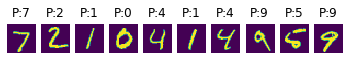

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

predictions = model.predict(x_test, verbose=0)
for i in range(10):
    subplt = plt.subplot(int(i / 10) + 1, 10, i + 1)
    # no sense in showing labels if they don't match the letter
    hot_index = np.argmax(predictions[i])
    subplt.set_title('P:{0}'.format(hot_index))
    subplt.axis('off')
    letter = x_test[i]
    subplt.matshow(np.reshape(letter, [28, 28]))
    plt.draw()
    
plt.show()